In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# alter view settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

In [12]:
# Stats imports
import statsmodels.api as sm
from scipy.stats import pearsonr

In [14]:
#Initial View function for initial impressions of dataframe
import textwrap
def initial_view(df):
    message = """\nColumns:\n{}\n\nHead:\n{}\n\nDescribe:\n{}\n\nPresent Count:\n\n{}\n\nMissing Count:\n\n{}
    """.format(df.columns,df.head(),df.describe().round(3),df.notna().sum().sort_values(ascending = False),df.isna().sum().sort_values(ascending = False))
    print(textwrap.dedent(message))

In [16]:
# import datasets
world_pop = pd.read_csv('World_Population_and_Health.csv')
gdp = pd.read_csv('GDP by Country 1999-2024.csv')
continents = pd.read_csv('Countries by continents.csv')

In [18]:
# get initial look at the data
# initial_view(world_pop)
# initial_view(gdp)
# initial_view(continents)

In [20]:
# function to make an id column for keys in two of the dataframes
def id(df):
    df['id'] = df.apply(lambda row: str(row['Year'])+"-"+row['Country'], axis=1)
    return df

In [22]:
# World Population data has a narrower range of years than GDP, see the list to narrow GDP
df_years = list(world_pop['Year'].unique())[:-1]

# listed in world_pop as Capo Verde (Portugese for Cape), translating for westerners
world_pop.loc[26, 'Country'] = 'Cape Verde'

# Create foreign key for world population data to map on to GDP data
id(world_pop)

,Country,Year,Population,country_code,health_exp,life_expect,maternal_mortality,infant_mortality,neonatal_mortality,under_5_mortality,prev_hiv,inci_tuberc,prev_undernourishment,id
0,Afghanistan,2014,56805036,AFG,9.528878,62.545,785.0,56.2,43.5,75.3,0.1,189.0,19.3,2014-Afghanistan
1,Albania,2014,127571863,ALB,6.434511,78.407,7.0,8.8,5.9,9.9,0.1,16.0,4.5,2014-Albania
2,Algeria,2014,147582820,DZA,6.547214,75.110,86.0,22.0,15.8,25.7,0.1,72.0,2.7,2014-Algeria
3,Andorra,2014,133274038,AND,6.773080,NaN,NaN,3.5,1.9,3.8,NaN,9.4,NaN,2014-Andorra
4,Angola,2014,35838921,AGO,2.434129,60.040,292.0,60.3,31.5,92.5,1.9,370.0,13.0,2014-Angola
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665,Uruguay,2023,69805797,URY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,2023-Uruguay
1666,Uzbekistan,2023,162931600,UZB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,NaN,2023-Uzbekistan
1667,Vanuatu,2023,84186452,VUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,NaN,2023-Vanuatu
1668,Zambia,2023,184919566,ZMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.0,NaN,2023-Zambia


In [24]:
# Cleans gdp to have it map onto world_pop
transposed_gdp = gdp.T.reset_index()

# Rename columns
col = ['Country'] + list(gdp['Unnamed: 0'])
transposed_gdp.columns = col

# Some of the countries are recorded differently between datasets. Fix some of them here
transposed_gdp.loc[1, 'Country'] = 'Afghanistan'

gdp_T = transposed_gdp[transposed_gdp['Country'] != 'Unnamed: 0']
lst = ['Country'] + df_years
gdp_T2 = gdp_T[lst].copy()

# Need to melt gdp_T2 to get a comparable dataframe and match primary keys to foreign keys
melt = pd.melt(
    gdp_T2, 
    id_vars= 'Country', 
    value_vars=['Country']+df_years, 
    var_name="Year", 
    value_name="GDP", 
)

# Naming Change: removed all after the comma to get more names that match between datasets
melt['Country'] = [x.split(',')[0] for x in melt['Country']]

id(melt)

,Country,Year,GDP,id
0,Afghanistan,2014,24.304,2014-Afghanistan
1,Albania,2014,16.053,2014-Albania
2,Algeria,2014,203.449,2014-Algeria
3,Angola,2014,151.089,2014-Angola
4,Antigua and Barbuda,2014,1.494,2014-Antigua and Barbuda
...,...,...,...,...
1615,Venezuela,2022,43.546,2022-Venezuela
1616,Vietnam,2022,415.493,2022-Vietnam
1617,Yemen,2022,0.000,2022-Yemen
1618,Zambia,2022,23.967,2022-Zambia


In [26]:
# Narrow out world_population df to focus on variables specific to this analysis
narrow = list(world_pop.keys()[:6])+['id']
narrow.remove('country_code')
world_pop_narrow = world_pop[narrow].copy()

In [28]:
# "Burkina Faso" (Africa) and "Timor-Leste" (Asia) are not listed in the continents df. Added here
additions = pd.DataFrame({"Continent":["Africa","Asia"],"Country":["Burkina Faso","Timor-Leste"]})
continents = pd.concat([continents,additions],ignore_index=True)

In [30]:
# Merging all data into one dataset GDP - Population - Continent (gpc, shortened for efficient coding) merge

# merging rearranging and trimming columns to fit process and for presentation later
    #merge
merge_1 = pd.merge(melt,world_pop_narrow,on='id')
    #trim merged columns into needed since there are repetitive names
merge_1 = merge_1[['id','Country_x','Year_x','GDP','Population','health_exp','life_expect']]
    #rename columns to help merge with continents df
merge_1.columns = ['id','Country','year','gdp','population','health_exp','life_expect']
    #merge with continents df
gpc_merge = pd.merge(merge_1, continents,on='Country',how='left')

gpc_merge = gpc_merge[['Continent','Country','year','gdp','life_expect','population','health_exp','id']].copy()

initial_view(gpc_merge)

# double check why continents missing -- resolved
# print(gpc_merge[gpc_merge['Continent'].isna()])

# Side Note -- USA is missing from world_pop data. Due to landmass and economic impact will avoid analysis on North America if using continents. Focus on Europe, South America and Asia instead.


Columns:
Index(['Continent', 'Country', 'year', 'gdp', 'life_expect', 'population', 'health_exp', 'id'], dtype='object')

Head:
       Continent              Country  year      gdp  life_expect  population  health_exp                        id
0           Asia          Afghanistan  2014   24.304       62.545    56805036    9.528878          2014-Afghanistan
1         Europe              Albania  2014   16.053       78.407   127571863    6.434511              2014-Albania
2         Africa              Algeria  2014  203.449       75.110   147582820    6.547214              2014-Algeria
3         Africa               Angola  2014  151.089       60.040    35838921    2.434129               2014-Angola
4  North America  Antigua and Barbuda  2014    1.494       77.858   133170466    5.872699  2014-Antigua and Barbuda

Describe:
             gdp  life_expect    population  health_exp
count   1351.000     1351.000  1.351000e+03    1211.000
mean     385.715       71.956  8.359281e+07       6.

In [32]:
# get our merged data to a csv. Useful backup or save some computing
gpc_merge.to_csv('gpc_merge.csv')

In [12]:
# Important lists going forward
continents_list = list(gpc_merge['Continent'].unique())
# print(continents_list)
# print(df_years)

# create dictionary of continents to organize data
continents_dict = {}
for x in continents_list:
    continents_dict[x] = gpc_merge[gpc_merge['Continent'] == x]

In [13]:
# create a dataframe of averages to show the broad strokes of the data
continent_averages_dict = {}

for x in continents_list:
    continent_averages_dict[x] = continents_dict[x].groupby('year').agg({'gdp':'mean','life_expect':'mean','population':'mean','health_exp':'mean'}).round(2)

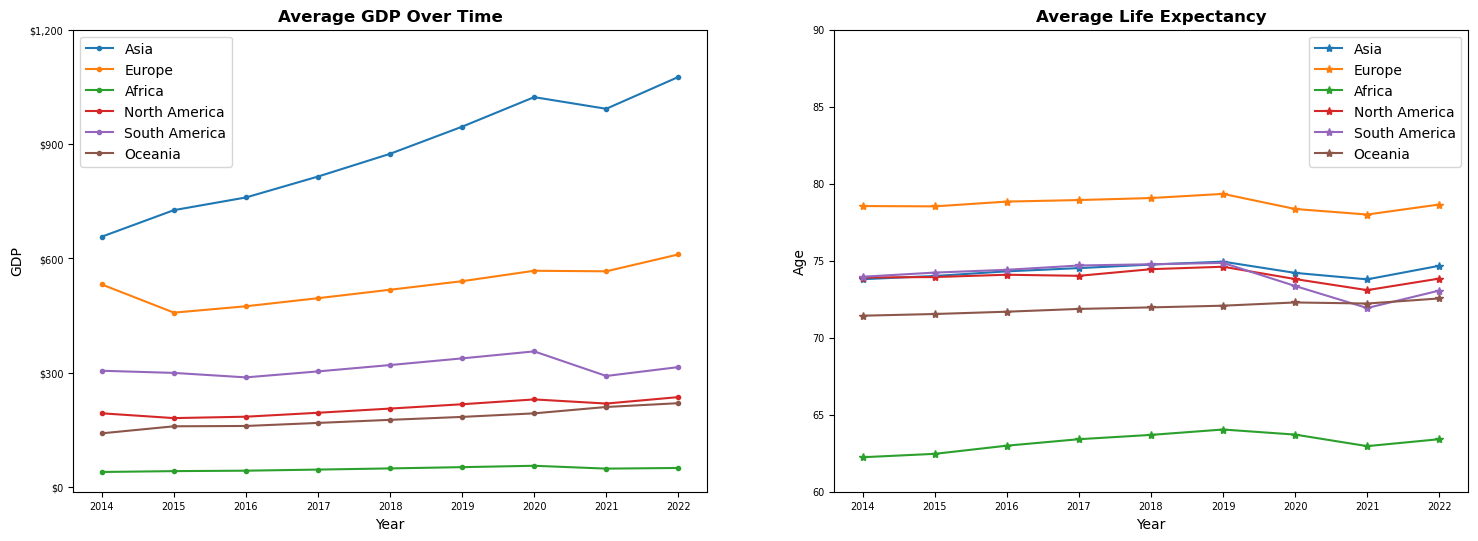

<Figure size 640x480 with 0 Axes>

In [14]:
# visualize gdp and life expectancy over the bracket of years
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(18,6))

# GDP visualization (left)
for x in continents_list:
    ax1.plot(continent_averages_dict[x].index,continent_averages_dict[x].gdp,marker=".")
ax1.legend(continents_list)
ax1.set_title("Average GDP Over Time",fontweight="bold")
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP")
ax1.set_yticks(range(0,1201,300))
ax1.set_yticklabels(["$"+str(round(x/1000,1)).replace(".",",")+"00" if x >= 1000 else "$"+str(x) for x in range(0,1201,300)],fontsize=7)
ax1.set_xticks(range(2014,2023))
ax1.set_xticklabels(range(2014,2023),fontsize=7)

# Life Expectancy visualization (right)
for x in continents_list:
    ax2.plot(continent_averages_dict[x].index,continent_averages_dict[x].life_expect,marker="*")
ax2.legend(continents_list)
ax2.set_xlabel("Year")
ax2.set_ylabel("Age")
ax2.set_title("Average Life Expectancy",fontweight="bold")
ax2.set_yticks(range(60,91,5))
ax2.set_yticklabels(range(60,91,5),fontsize=7)
ax2.set_xticks(range(2014,2023))
ax2.set_xticklabels(range(2014,2023),fontsize=7)

plt.savefig("continent_average_gdp_lifeexpect_over_time.jpg")
plt.show()
plt.clf()


# Seems that the most missing data is in 2023 which drives the average up (less values to divide by). Changing earlier in the code to exclude.
# for x in continents_dict["Europe"]["Country"].unique():
#     print(continents_dict["Europe"]["gdp"][continents_dict["Europe"]["Country"] == x])

# for x in continents_list:
#     print(continent_averages_dict[x]['gdp'][2022], continent_averages_dict[x]['gdp'][2023])


In [15]:
# function to get the top n countries of a continent on a measure averaged over the time span
def continent_country_measure_dict_top_n(continent,measure,n):
    temp = {}
    lst = continents_dict[continent].groupby('Country').agg({measure:'mean'}).round(2).sort_values(by=measure,ascending=False)
    top_n_list = lst.index[:n]
    for i in top_n_list:
        temp[i] = continents_dict[continent][continents_dict[continent]["Country"] == i]
    return temp, top_n_list

# check work
# asia_top_5_dict, asia_top_5_lst = continent_country_measure_dict_top_n("Asia","gdp",5)
# print(asia_top_5)

In [16]:
# Since Asia and Europe have the highest averages, focus on these continent and the top 5 countries

# asia gdp and life expectancy:
asia_top_gdp_dict, asia_top_gdp_list = continent_country_measure_dict_top_n("Asia","gdp",5)
asia_top_le_dict, asia_top_le_list = continent_country_measure_dict_top_n("Asia","life_expect",5)

# europe gdp and life expectancy:
europe_top_gdp_dict, europe_top_gdp_list = continent_country_measure_dict_top_n("Europe","gdp",5)
europe_top_le_dict, europe_top_le_list = continent_country_measure_dict_top_n("Europe","life_expect",5)

# check work
# for x in asia_top_gdp_list:
#     print(asia_top_gdp_dict[x])

In [17]:
# function to visualize europe and asia's gdp and life expectancy
def visualize_two_var_over_time(continent,measure1,measure2,df1,lst1,df2,lst2,save_name):
    # underpinning variables
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,7))
    y_max1 = round(np.max(df1[lst1[0]][measure1]))
    y_min1 = round(np.min(df1[lst1[-1]][measure1]))
    y_max2 = round(np.max(df2[lst2[0]][measure2]))
    y_min2 = round(np.min(df2[lst2[-1]][measure2]))
    
    # plot measure1
    count = 0
    cmap1 = plt.cm.Set1
    for x in lst1:
        color=cmap1(count / (len(lst1) - 1))
        ax1.plot(df_years,df1[x][measure1],color = color, marker=".", label=x)
        count += 1

    # clean label for presentation on graph
    if "_" in measure1:
        y1_label = measure1.replace("_"," ").upper()
    else:
        y1_label = measure1.upper()

    # set title and labels
    ax1.set_title(continent+ " - "+ y1_label.upper(),fontweight="bold")
    ax1.set_xlabel("Years",fontweight="bold")
    ax1.set_ylabel(y1_label,fontweight="bold")

    # create even, representative intervals for y-axis
    y_interval1 = int(round(((y_max1-y_min1)/10))+1)
    y_lower1 = y_min1-1-y_interval1
    if y_lower1 < 0:
        y_lower1 = 0
    y_upper1 = y_max1+1+y_interval1
    y_range1 = range(y_lower1,y_upper1,y_interval1)
    ax1.set_yticks(y_range1)
    if measure1 == 'gdp':
        ax1.set_yticklabels(["$"+str(round(x/1000,1)).replace(".",",")+"00" if x >= 1000 else "$"+str(x) for x in y_range1],fontsize=7)
    else:
        ax1.set_yticklabels(y_range1,fontsize=7)

    #  create year_labels
    ax1.set_xticks(range(2014,2023))
    ax1.set_xticklabels(range(2014,2023),fontsize=7)
    ax1.legend()

    
    # plot measure2
    count2 = 0
    cmap2 = plt.cm.Accent
    for y in lst2:
        color = cmap2(count2 / (len(lst2) - 1))
        ax2.plot(df_years,df2[y][measure2],color=color,marker="*", label=y)
        count2 += 1

    # clean label for presentation on graph
    if "_" in measure2:
        y2_label = measure2.replace("_"," ").upper()
    else:
        y2_label = measure2.upper()    

    # set title and labels
    ax2.set_title(continent+ " - " + y2_label.title(),fontweight="bold")
    ax2.set_xlabel("Years",fontweight="bold")
    ax2.set_ylabel(y2_label,fontweight="bold")

    # create even, representative intervals for y-axis
    y_interval2 = int(round(((y_max2-y_min2)/10))+1)
    y_lower2 = y_min2-1-y_interval2
    if y_lower2 < 0:
        y_lower2 = 0
    y_upper2 = y_max2+1+y_interval2
    y_range2 = range(y_lower2,y_upper2,y_interval2)
    ax2.set_yticks(y_range2)
    if measure2 == 'gdp':
        ax2.set_yticklabels(["$"+str(round(x/1000,1)).replace(".",",")+"00" if x >= 1000 else "$"+str(x) for x in y_range2],fontsize=7)
    else:
        ax2.set_yticklabels(y_range2,fontsize=7)

    # set year_labels
    ax2.set_xticks(range(2014,2023))
    ax2.set_xticklabels(range(2014,2023),fontsize=7)
    ax2.legend(loc="lower left")

    # save, show and close
    plt.savefig(save_name)
    plt.show()
    plt.clf()

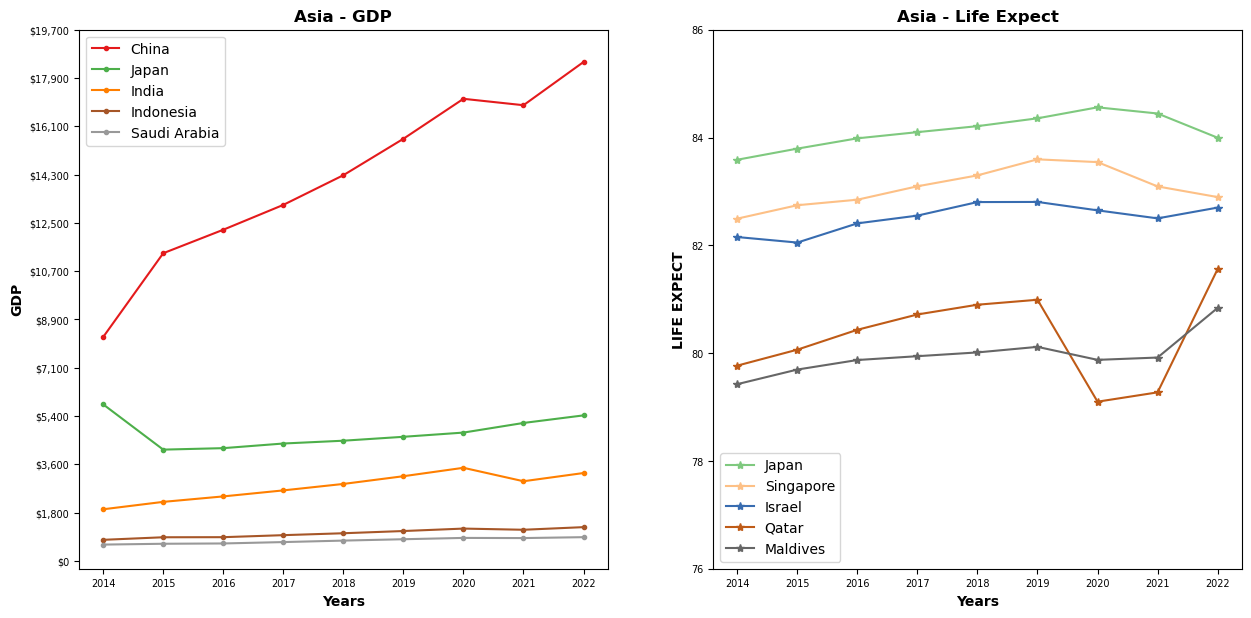

<Figure size 640x480 with 0 Axes>

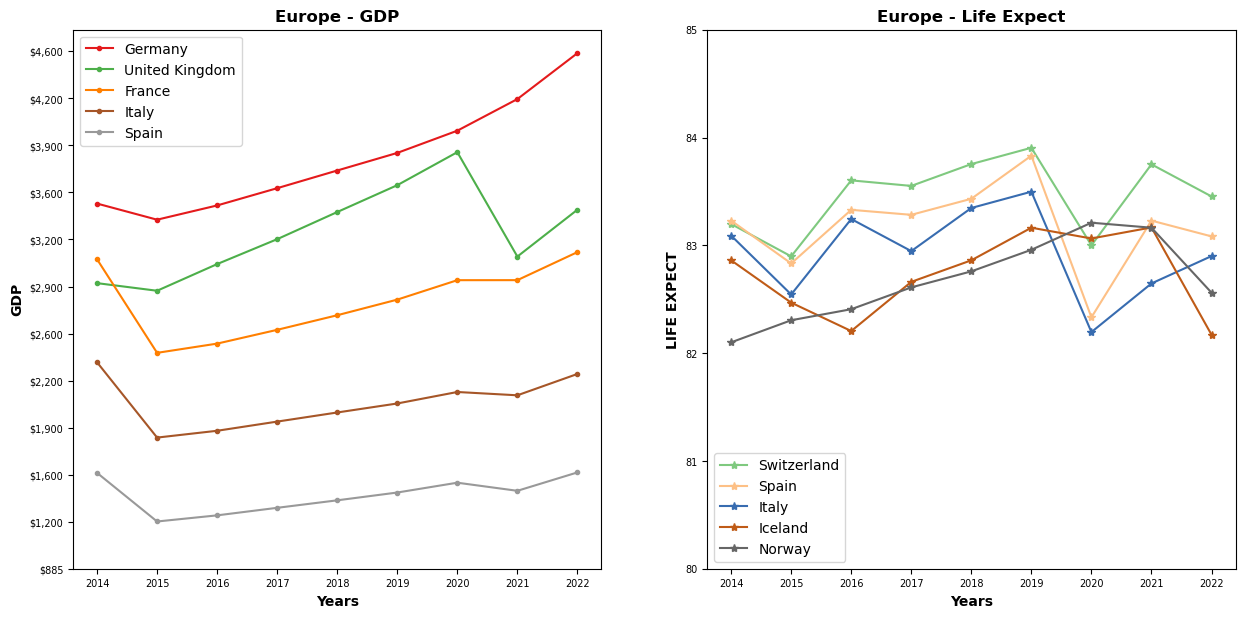

<Figure size 640x480 with 0 Axes>

In [18]:
visualize_two_var_over_time("Asia","gdp","life_expect",asia_top_gdp_dict,asia_top_gdp_list,asia_top_le_dict,asia_top_le_list,"asia_gdp_le.jpg")
visualize_two_var_over_time("Europe","gdp","life_expect",europe_top_gdp_dict,europe_top_gdp_list,europe_top_le_dict,europe_top_le_list,"europe_gdp_le.jpg")

In [19]:
# visualize_two_var_over_time("Asia","gdp","life_expect",asia_top_gdp_dict,asia_top_gdp_list,asia_top_le_dict,asia_top_le_list,"asia_gdp_le.jpg")
# visualize_two_var_over_time("Europe","gdp","life_expect",europe_top_gdp_dict,europe_top_gdp_list,europe_top_le_dict,europe_top_le_list,"europe_gdp_le.jpg")

In [20]:
# correlational analysis to drive the point home
# print(asia_top_gdp_dict)

def gdp_le_scatter_tops(*df):
    count = 1
    for x in df:
        data = x[list(x.keys())[0]]
        ax = plt.subplot()
        plt.scatter(data['gdp'],data['life_expect'])

        # 
        y_max = round(np.max(data['life_expect']))
        y_min = round(np.min(data['life_expect']))
        x_max = round(np.max(data['gdp']))
        x_min = round(np.min(data['gdp']))

        # line of best fit
        model = sm.OLS.from_formula('gdp ~ life_expect',data)
        results = model.fit()
        
        # Fit the model using statsmodels
        X = sm.add_constant(data['gdp'])  # Adds a constant term (intercept) to the predictor
        model = sm.OLS(data['life_expect'], X).fit()
        
        # Get predictions for the line of best fit
        x_pred = np.linspace(x_min, x_max, 100)  # Generate x values for prediction
        X_pred = sm.add_constant(x_pred)  # Add constant for prediction
        y_pred = model.predict(X_pred)

        plt.plot(x_pred, y_pred, linestyle="--", color="red")

        # calculate correlation
        corr, p = pearsonr(data['gdp'],data['life_expect'])
        
        # handle the life expectancy axis
        y_interval = int(round(((y_max-y_min)/5))+1)
        y_lower = y_min-1-y_interval
        if y_lower < 0:
            y_lower = 0
        y_upper = y_max+1+y_interval
        y_range = range(y_lower,y_upper,y_interval)
        ax.set_yticks(y_range)
        ax.set_yticklabels(y_range,fontsize=7)
        
        # handle the gdp axis
        x_interval = int(round(((x_max-x_min)/5))+1)
        x_lower = x_min-1-x_interval
        if x_lower < 0:
            x_lower = 0
        x_upper = x_max+1+x_interval
        x_range = range(x_lower,x_upper,x_interval)
        ax.set_xticks(x_range)
        ax.set_xticklabels(["$"+str(round(x/1000,1)).replace(".",",")+"00" if x >= 1000 else "$"+str(x) for x in x_range],fontsize=7)
        
        # x and y label
        plt.xlabel('GDP')
        plt.ylabel('Life Expectancy')

        # title and show
        plt.title(list(x.keys())[0] + ' - GDP v. Life Expectancy: r = ' + str(round(corr,2)),fontweight='bold')
        plt.savefig(str(list(x.keys())[0])+'_gdp_le_corr.jpg')
        plt.show()

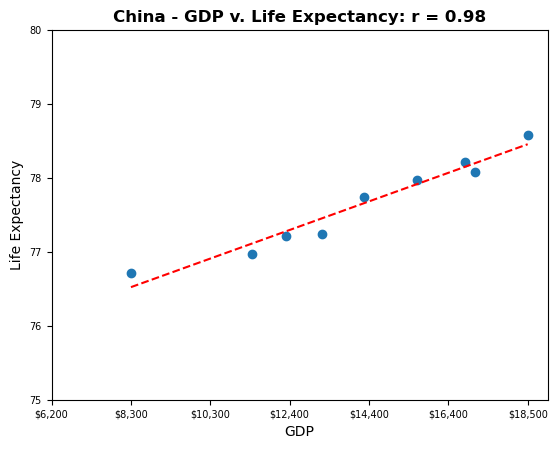

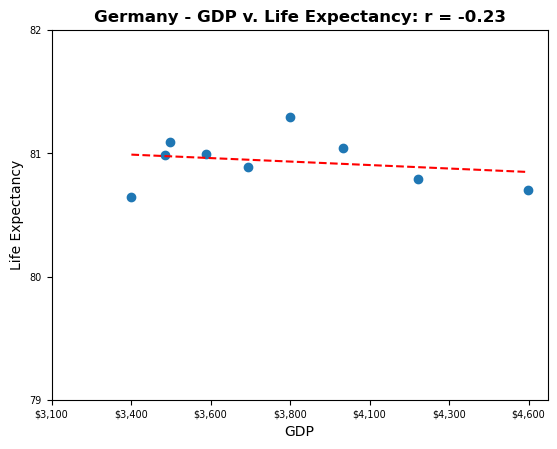

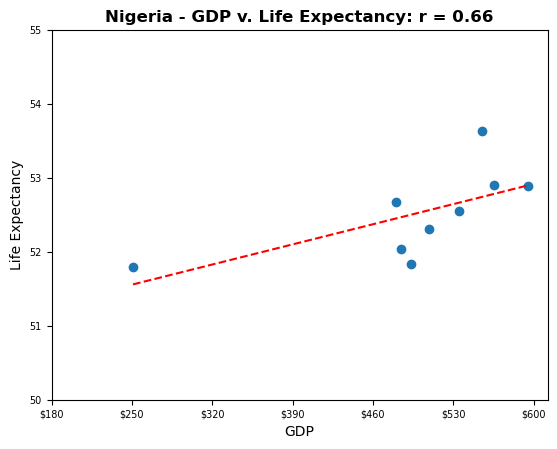

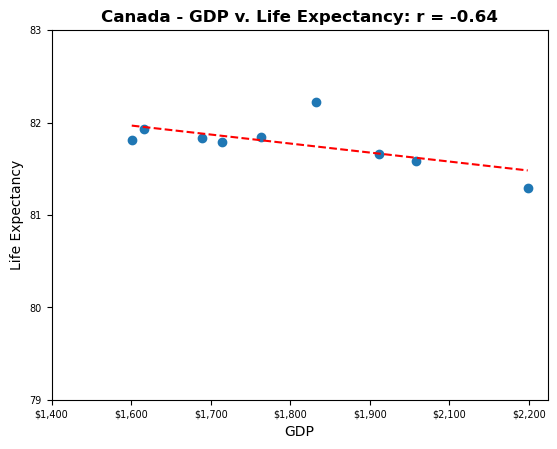

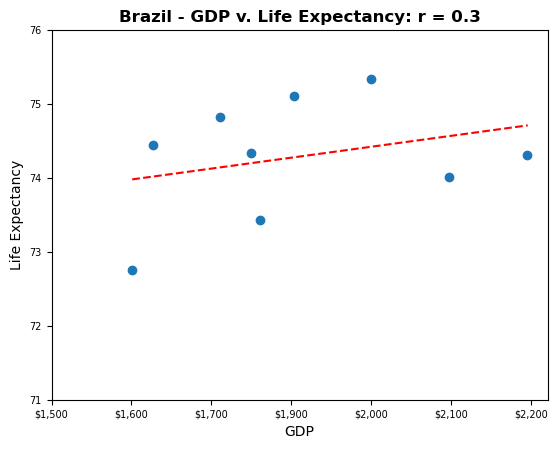

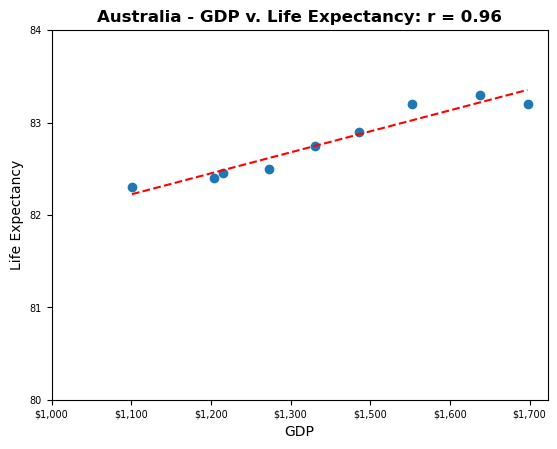

In [21]:
# dict, list = continent_country_measure_dict_top_n(continent,measure,n)
africa_gdp_dict, africa_gdp_list = continent_country_measure_dict_top_n('Africa','gdp',5)
na_gdp_dict, na_gdp_lst = continent_country_measure_dict_top_n('North America','gdp',5)
sa_gdp_dict, sa_gdp_lst = continent_country_measure_dict_top_n('South America','gdp',5)
o_gdp_dict, o_gdp_lst = continent_country_measure_dict_top_n('Oceania', 'gdp', 5)

gdp_le_scatter_tops(asia_top_gdp_dict, europe_top_gdp_dict, africa_gdp_dict, na_gdp_dict, sa_gdp_dict, o_gdp_dict)

In [23]:
def gdp_le_scatter_country(df):
    for x in continents_list:
        # showing data within the iqr because the data seemed off
        lower_quart = np.quantile(df[x]['gdp'],.25)
        upper_quart = np.quantile(df[x]['gdp'],.75)
        data = df[x][(df[x]['gdp'] >= lower_quart) | (df[x]['gdp'] <= upper_quart)].dropna(subset='gdp')
        ax = plt.subplot()
        plt.scatter(data['gdp'],data['life_expect'])
    
        # x and y minimums and maximums
        y_max = round(np.max(data['life_expect']))
        y_min = round(np.min(data['life_expect']))
        x_max = round(np.max(data['gdp']))
        x_min = round(np.min(data['gdp']))
    
        # line of best fit
        model = sm.OLS.from_formula('gdp ~ life_expect',data)
        results = model.fit()
        
        # Fit the model using statsmodels
        X = sm.add_constant(data['gdp'])  # Adds a constant term (intercept) to the predictor
        model = sm.OLS(data['life_expect'], X).fit()
        
        # Get predictions for the line of best fit
        x_pred = np.linspace(x_min, x_max, 100)  # Generate x values for prediction
        X_pred = sm.add_constant(x_pred)  # Add constant for prediction
        y_pred = model.predict(X_pred)
    
        plt.plot(x_pred, y_pred, linestyle="--", color="red")
    
        # calculate correlation
        corr, p = pearsonr(data['gdp'],data['life_expect'])
        
        # handle the life expectancy axis
        y_interval = int(round(((y_max-y_min)/5))+1)
        y_lower = y_min-1-y_interval
        if y_lower < 0:
            y_lower = 0
        y_upper = y_max+1+y_interval
        y_range = range(y_lower,y_upper,y_interval)
        ax.set_yticks(y_range)
        ax.set_yticklabels(y_range,fontsize=7)
        
        # handle the gdp axis
        x_interval = int(round(((x_max-x_min)/5))+1)
        x_lower = x_min-1-x_interval
        if x_lower < 0:
            x_lower = 0
        x_upper = x_max+1+x_interval
        x_range = range(x_lower,x_upper,x_interval)
        ax.set_xticks(x_range)
        ax.set_xticklabels(["$"+str(round(x/1000,1)).replace(".",",")+"00" if x >= 1000 else "$"+str(x) for x in x_range],fontsize=7)
        
        # x and y label
        plt.xlabel('GDP')
        plt.ylabel('Life Expectancy')
    
        # title and show
        plt.title(x + '(iqr) - GDP v. Life Expectancy: r = ' + str(round(corr,2)),fontweight='bold')
        plt.savefig(x+'iqr_gdp_le_corr.jpg')
        plt.show()

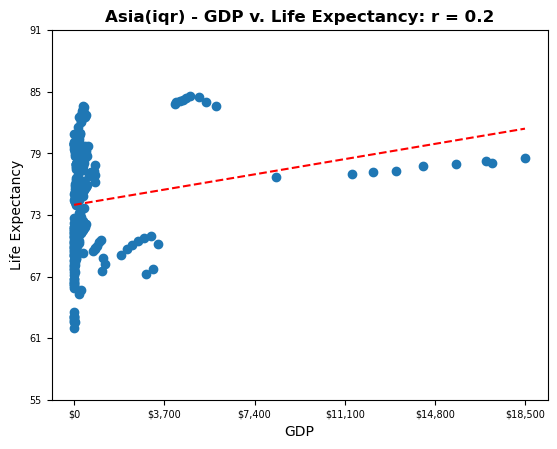

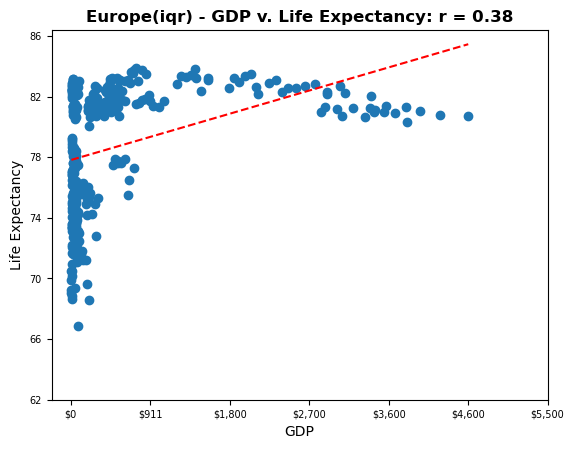

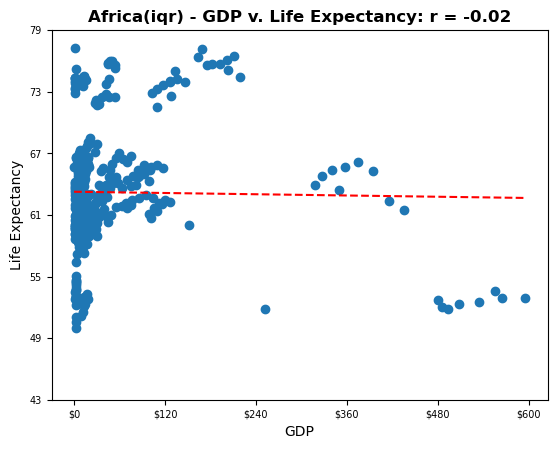

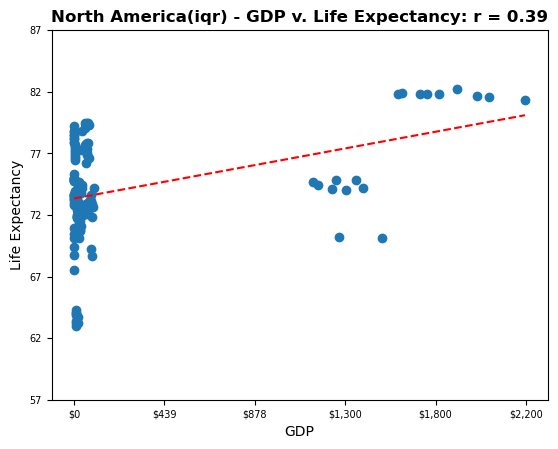

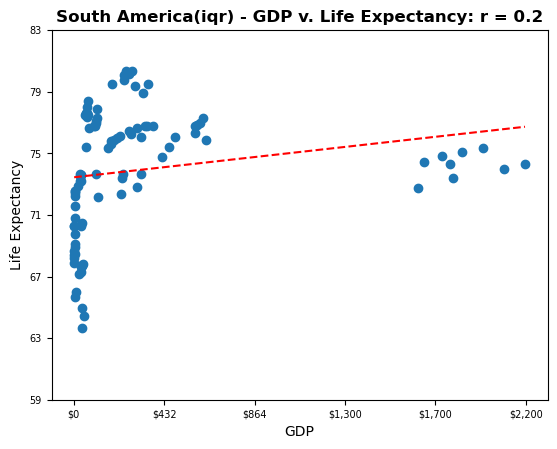

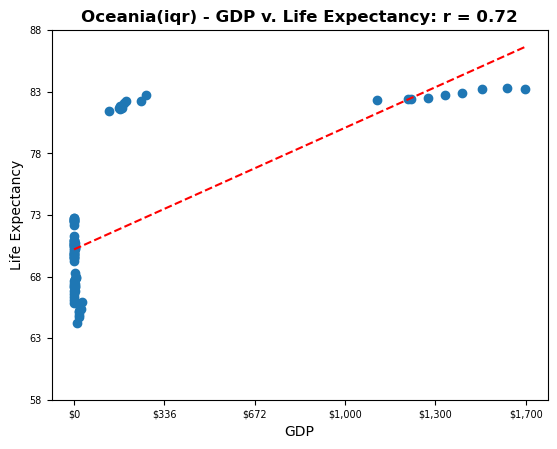

In [24]:
gdp_le_scatter_country(continents_dict)

In [25]:
# Appendix analysis: What components are driving up or down life expectancy? More indications of healthcare investment/expenditure? A more macabre portion of the presentation, so save for Q&A/end
# Not including GDP with this dataframe, will not be used in further analysis
world_pop = world_pop[world_pop['Year'] != 2023]
    #2023 also has a good bit of missing data here, excluding for the same reason as GDP
mort_merge = pd.merge(world_pop,continents,on='Country').sort_values(by='Year')
mort_merge.columns = ['country','year','population','code','health_exp','life_expect','maternal_mort','infant_mort','neonatal_mort','under_five_mort','prev_hiv','inci_tuberc','prev_undernourishment','id','continent']
final_mort_merge = mort_merge[['country','continent','year','population','health_exp','life_expect','maternal_mort','infant_mort','neonatal_mort','under_five_mort','prev_hiv','inci_tuberc','prev_undernourishment']]

# check work
print(final_mort_merge)

          country      continent  year  population  health_exp  life_expect  maternal_mort  infant_mort  neonatal_mort  under_five_mort  prev_hiv  inci_tuberc  prev_undernourishment
0     Afghanistan           Asia  2014    56805036    9.528878    62.545000          785.0         56.2           43.5             75.3       0.1        189.0                   19.3
106         Nepal           Asia  2014    23891962    5.080000    68.085000          253.0         32.4           23.9             39.9       0.2        276.0                    7.6
107   Netherlands         Europe  2014    66884972   10.570000    81.707317            5.0          3.5            2.7              4.1       0.2          5.5                    2.5
108   New Zealand        Oceania  2014    23043420    9.401684    81.456829            8.0          4.7            3.2              5.7       0.1          7.6                    2.5
109     Nicaragua  North America  2014    62240751    7.977161    72.812000           81.0

In [26]:
# organize into continents dictionary
mort_continents_dict= {}
for x in continents_list:
    mort_continents_dict[x] = final_mort_merge[final_mort_merge['continent'] == x]

# check work
# print(mort_continents_dict)

# get averages by continent
mort_continent_averages = {}
for x in continents_list:
    mort_continent_averages[x] = mort_continents_dict[x].groupby('year').agg({'population':'mean','health_exp':'mean','life_expect':'mean','maternal_mort':'mean','infant_mort':'mean',
                                                                              'neonatal_mort':'mean','under_five_mort':'mean','prev_hiv':'mean','inci_tuberc':'mean',
                                                                              'prev_undernourishment':'mean'}).round(2)
# check work
# print(mort_continent_averages)

In [27]:
def sns_scatter(continent,measure1,measure2):
    data = mort_continent_averages[continent].dropna()
    sns.lmplot(x=measure1,y=measure2,data=data,line_kws={"color": "red", "linestyle": "--", "linewidth": 2})
    corr, p = pearsonr(data[measure1],data[measure2])
    plt.title(x + ' - ' + measure1.replace("_"," ").title() + ' & ' + measure2.replace("_"," ").title() + " r = " + str(round(corr,2)))
    plt.xlabel(measure1.replace("_"," "))
    plt.ylabel(measure2.replace("_"," "))
    plt.show()

In [28]:
# find neonatal and maternal mortality correlations and print scatters

# mission creep, this isn't necessary for the presentation but may be useful to satisfy some curiosity. Simplify to a heatmap

# for x in continents_list:
#     sns_scatter(x,'maternal_mort','neonatal_mort')
#     sns_scatter(x,'maternal_mort','infant_mort')
    #sns_scatter(x,'infant_mort','under_five_mort') #same throughout, disregard

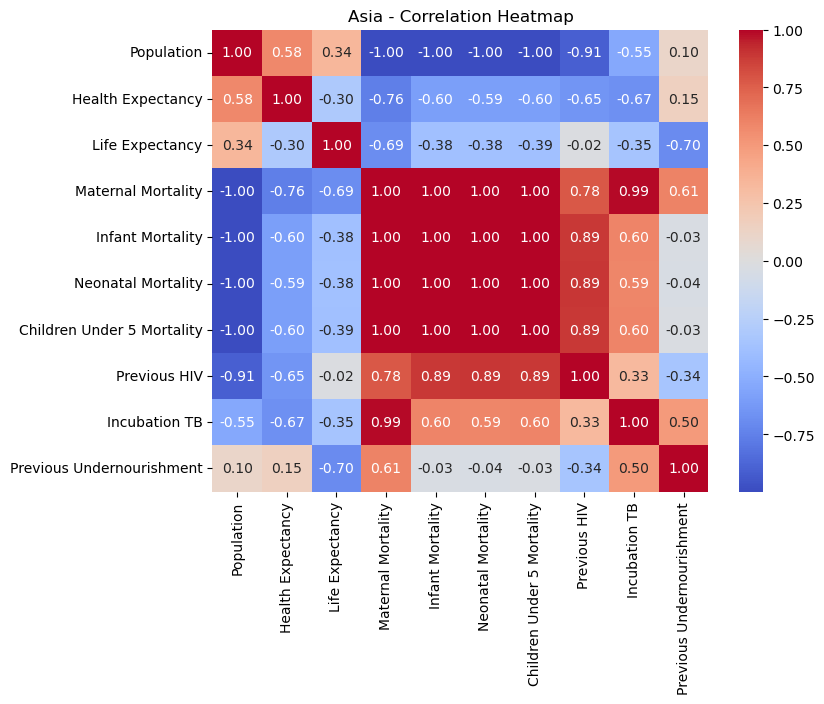

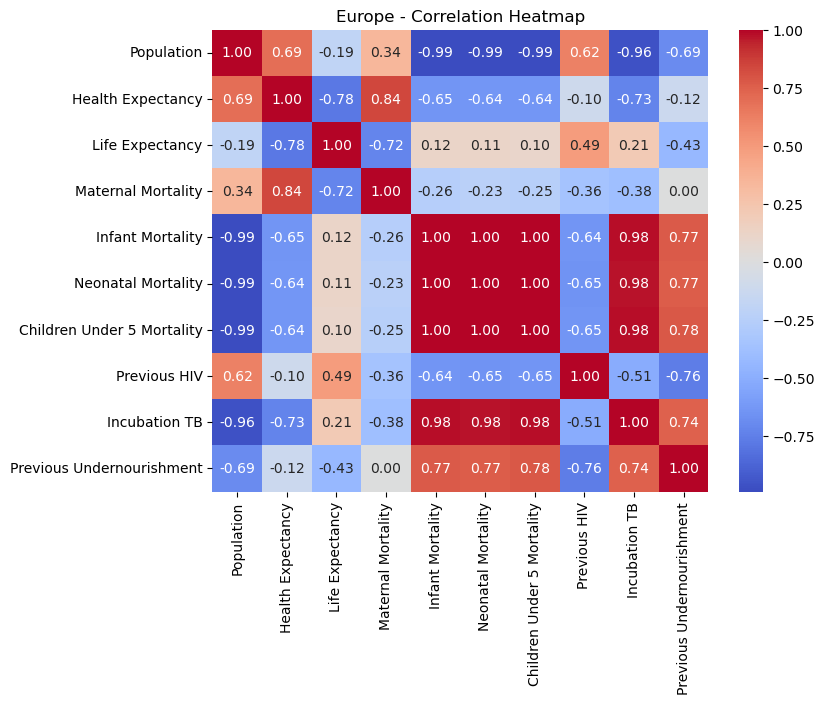

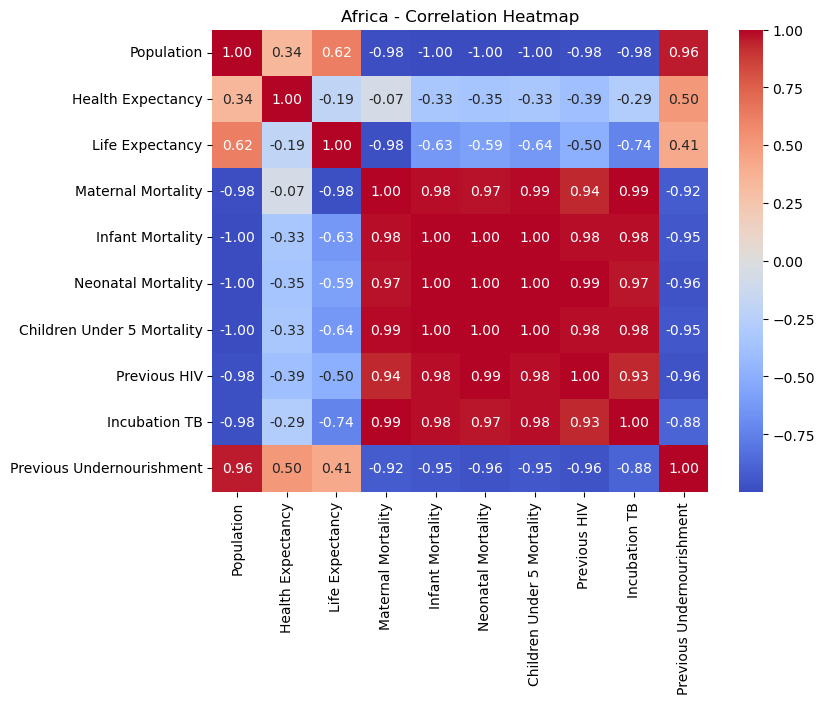

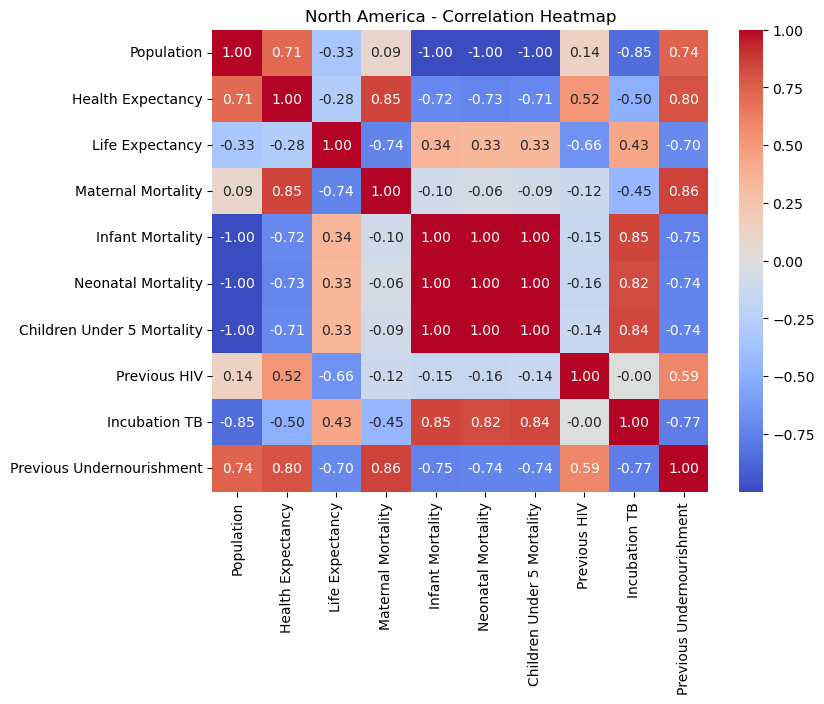

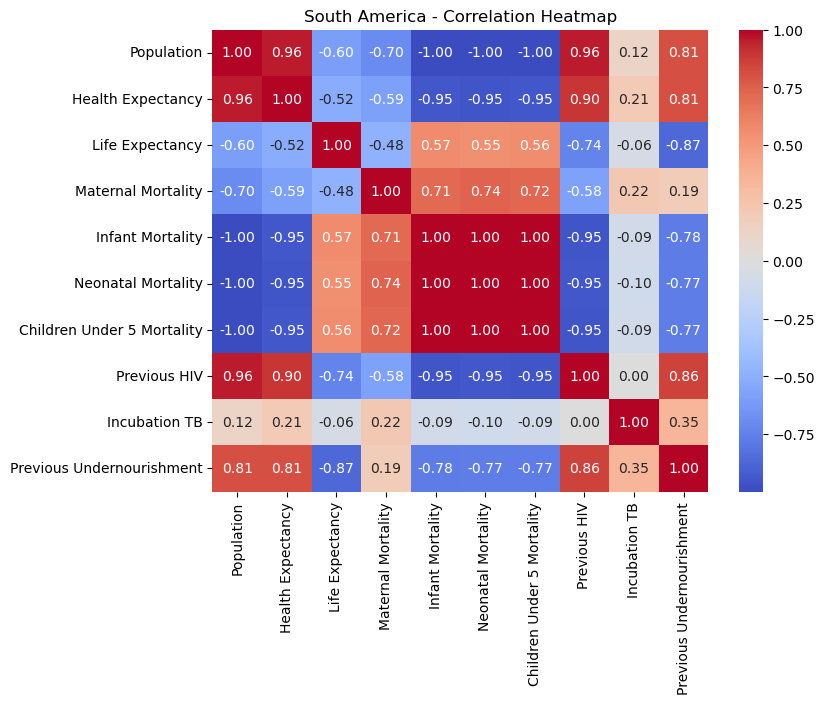

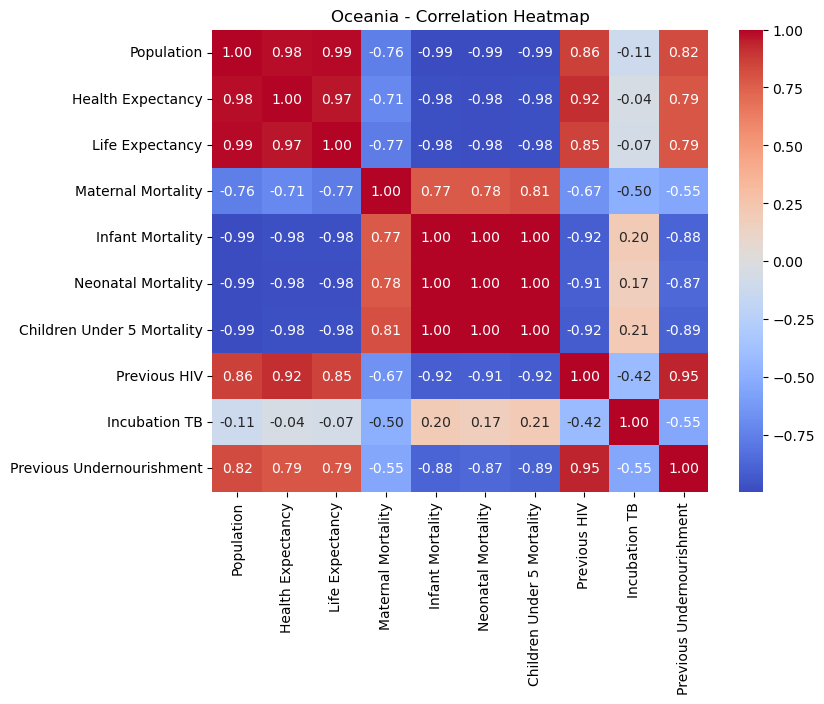

In [63]:
# heatmap for each continent
for x in continents_list:
    data = mort_continent_averages[x]
    data.columns = ['Population','Health Expectancy','Life Expectancy','Maternal Mortality','Infant Mortality','Neonatal Mortality','Children Under 5 Mortality','Previous HIV','Incubation TB','Previous Undernourishment']
    correlation_matrix = data.corr()
    
    # Step 2: Create a heatmap
    plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(x + " - Correlation Heatmap")
    plt.savefig(x+'_corr_heatmap.jpg')
    plt.show()